In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention,CrossAttention
import sys,os
from sklearn.model_selection import KFold
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [4]:
df_hd_tp_cdc = pd.read_csv('evaluation_set/cdc_ibm/headline_topic_mapping.csv')
df_ar_cl_cdc = pd.read_csv('evaluation_set/cdc_ibm/article_claim_mapping.csv')
df_hd_tp_dnf = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V2.json')
with open('evaluation_set/cdc_ibm/articles.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/cdc_ibm/article_vectors.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
df_hd_tp_cdc.keys(),df_ar_cl_cdc.keys(), len(articles.keys()), len(article_vectors.keys()), df_hd_tp_dnf.keys()

(Index(['Topic', 'Title', 'article Id', 'Headline'], dtype='object'),
 Index(['Unnamed: 0', 'Topic', 'Article', 'Claim'], dtype='object'),
 522,
 522,
 Index(['authors', 'evidence', 'headline', 'id', 'reason', 'sentences', 'type',
        'urls'],
       dtype='object'))

In [16]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 5000

l_arr = []
for idx in articles.keys():
    l_arr.append(len(articles[idx]))
        
max_sentences = np.max(l_arr)
max_sentences

1273

In [6]:
test_titles = []
for ar in df_ar_cl_cdc.Article.unique():
    if len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values)>8:
        test_titles.append(ar)

In [8]:
titles = sorted(df_hd_tp_cdc.Title.unique())
non_test_titles = np.array(list(set(titles)-set(test_titles)))

In [9]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [10]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

(380, 95, 47)

In [8]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [9]:
def datagen_cdc(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds=[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        hd = dataframe[dataframe.Title==idx]['Headline'].values[0].lower()
        hds.append(hd)
        ar_id = dataframe[dataframe.Title==idx]['article Id'].values[0]
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        vectors = article_vectors[ar_id]
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'headline_vector': np.array(ar_head_vectors)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes=[],[],[],[]
            counter=0
            
def datagen_dnf(batchsize,dataframe):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds=[],[],[],[],[]
    while True:
        idx=np.random.choice(dataframe.id.nunique())
        hd = dataframe[dataframe.id==idx]['headline'].values[0]
        ar_id = dataframe[dataframe.id==idx]['id'].values[0]
        cl = dataframe[dataframe.id==idx]['sentences'].values[0]
        hds.append(hd)
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
        with open('evaluation_set/deepnofakes/cleaned/article_{0}.txt'.format(ar_id)) as f:
            article = f.readlines()
            
        article=''.join(article)
        # print(article)
        article = article.replace('[REF]','')
        doc = sentencizer(article)
        sentences = [sent.string.strip() for sent in doc.sents]
    
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        vectors = []
        for s in sentences:
            vectors.append(nlp(s.lower()).vector)
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'headline_vector': np.array(ar_head_vectors)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes=[],[],[],[]
            counter=0
            

In [10]:
tdg = datagen_cdc(train_batchsize,df_hd_tp_cdc,mode='train')
vdg = datagen_cdc(val_batchsize,df_hd_tp_cdc,mode='val')
test_dg = datagen_cdc(test_batchsize,df_hd_tp_cdc,mode='test')

In [11]:
x,y = next(test_dg)

In [12]:
x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

((50, 1300, 300), (50, 300), (50, 50, 20000))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 1300, 300)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1300, 16)     14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1300, 16)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1300, 32)     1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

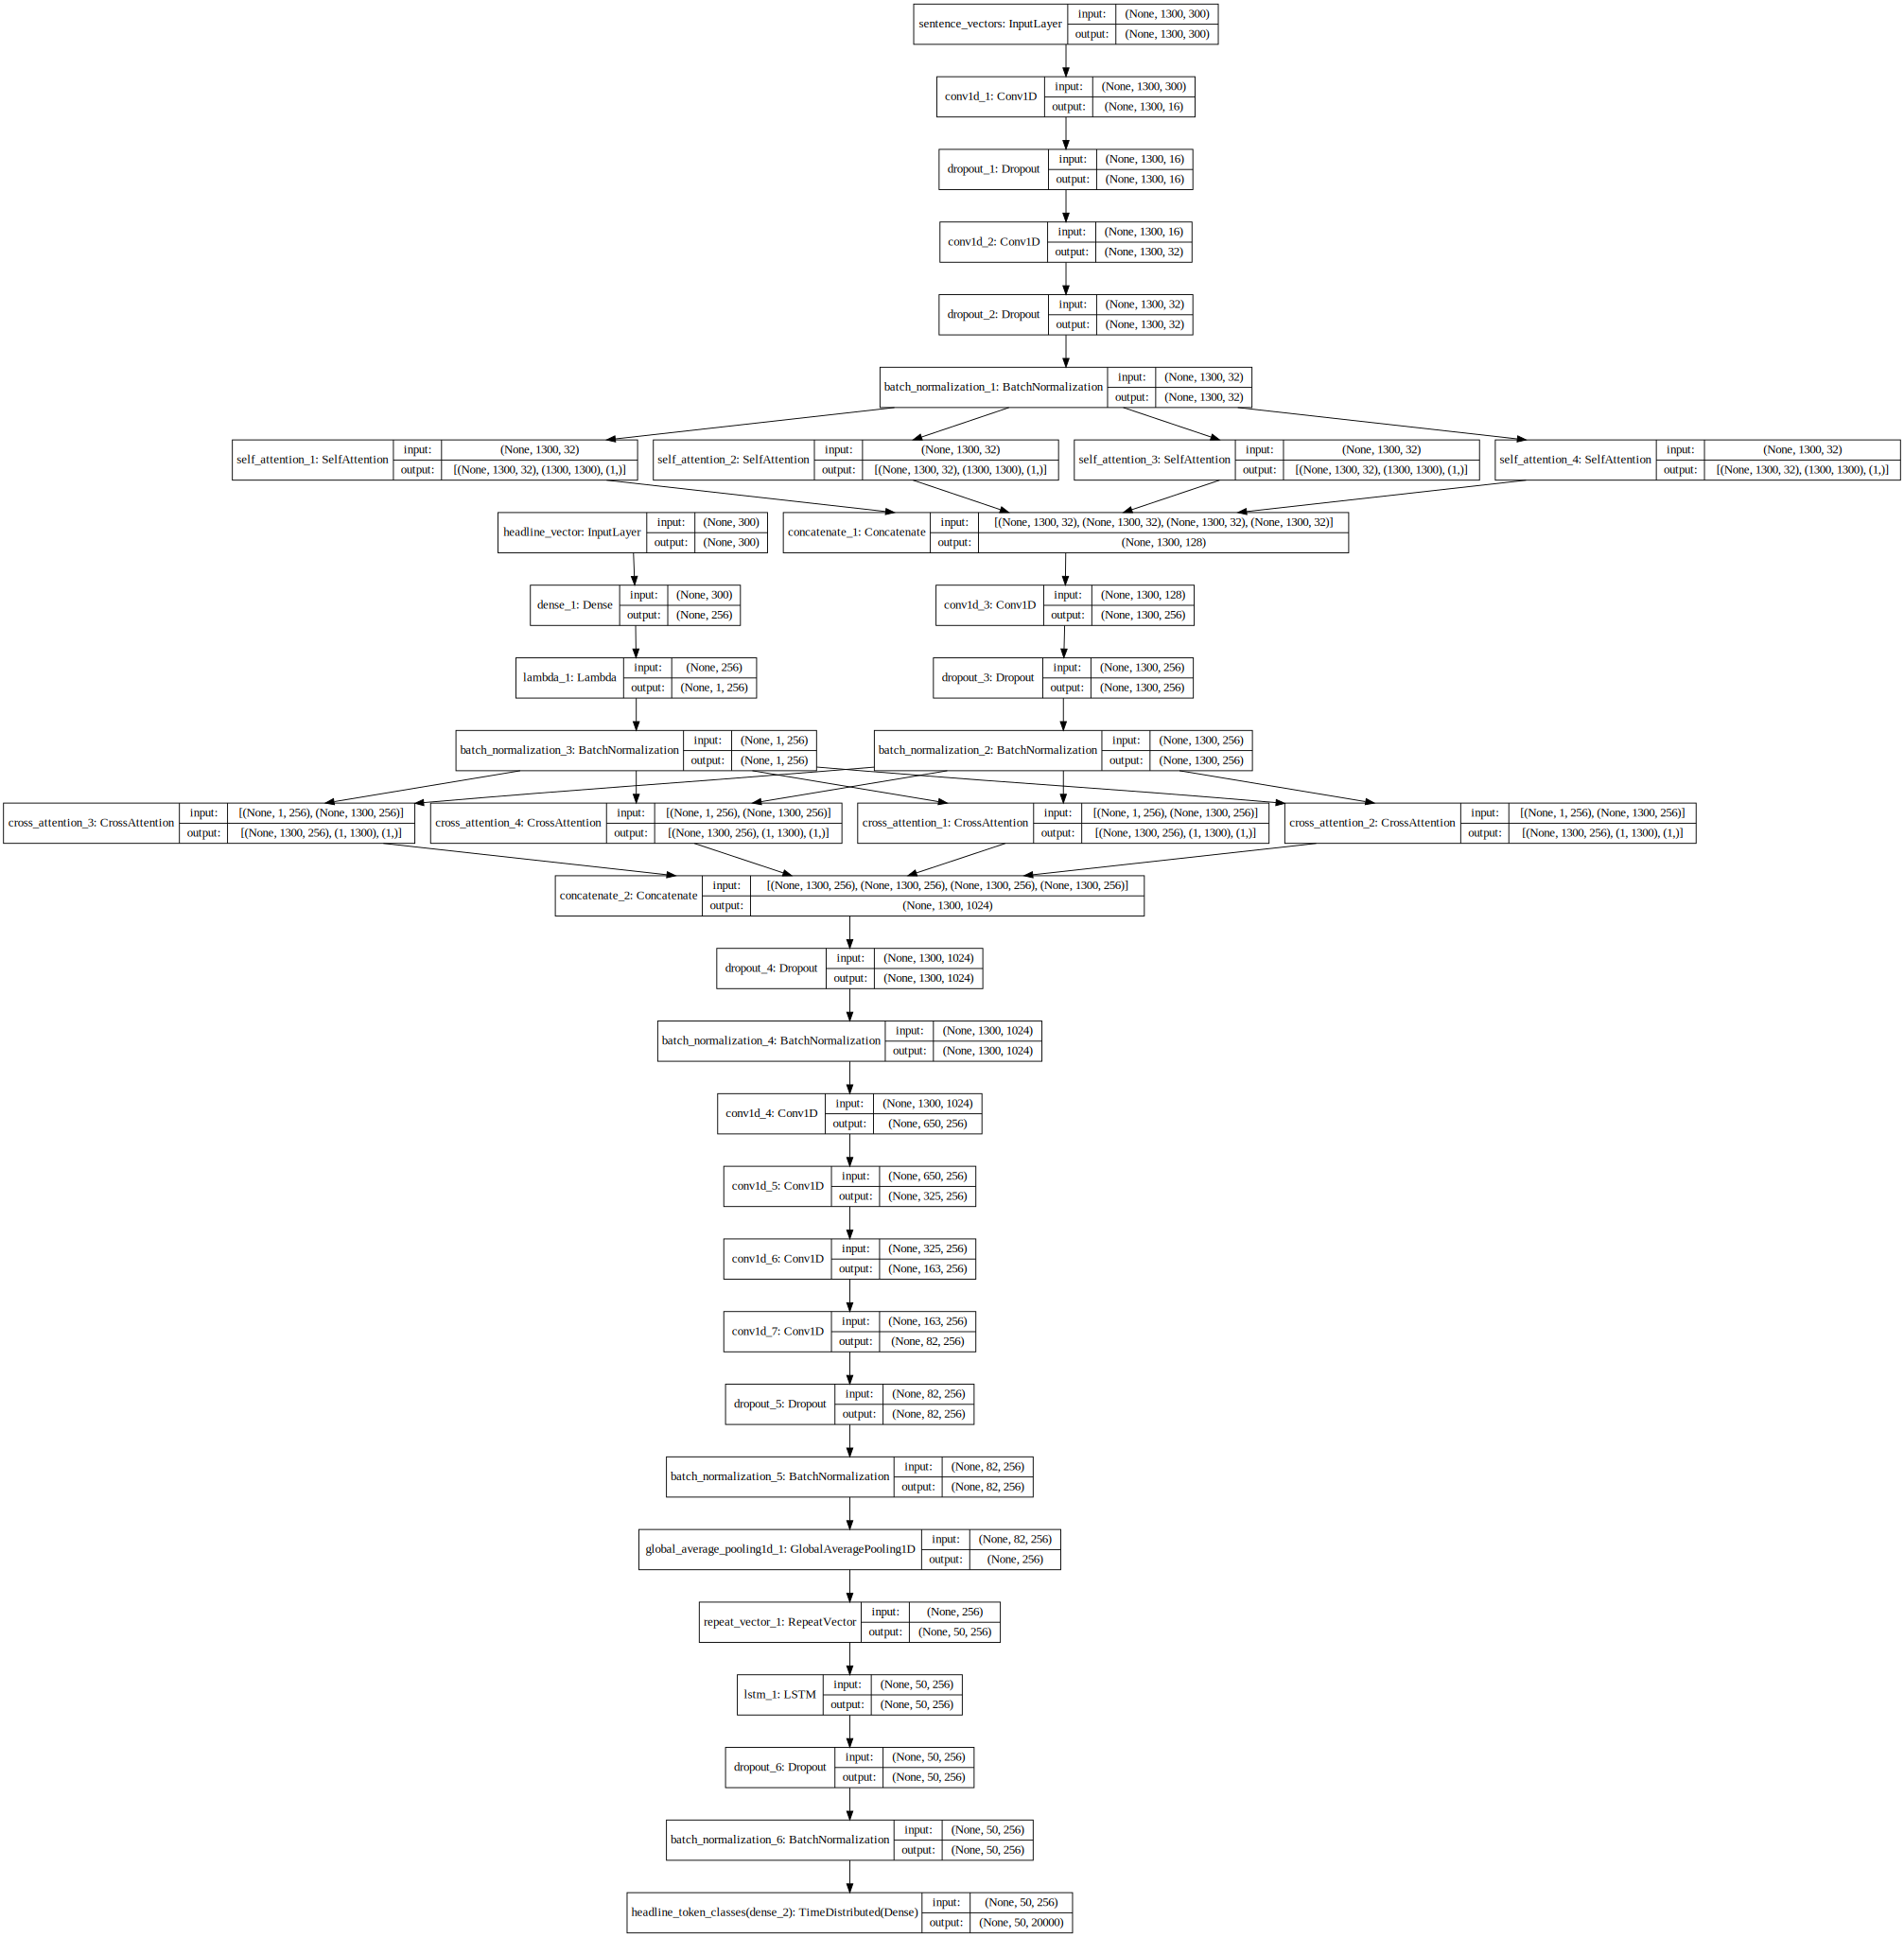

In [13]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]))(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]))([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]))([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]))([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]))([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
    repeat = RepeatVector(50)(gap)
    lstm1 = LSTM(256,return_sequences=True, activation='relu')(repeat)
    lstm1 = Dropout(0.5)(lstm1)
    lstm1 = BatchNormalization()(lstm1)
    gen_hd_vector = TimeDistributed(Dense(20000,activation='softmax'), name='headline_token_classes')(lstm1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [14]:
dt = datetime.now()
mc = ModelCheckpoint('weights/cdc_sa_sent_hd_word.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/cdc_sa_sent_hd_word/{0}'.format(dt.timestamp()),write_graph=True)

In [ ]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 13421/50000
4/4 [==============================] - 11s 3s/step - loss: 0.8688 - acc: 0.8384 - val_loss: 1.0640 - val_acc: 0.8275
Epoch 13422/50000
4/4 [==============================] - 11s 3s/step - loss: 0.8113 - acc: 0.8481 - val_loss: 0.8584 - val_acc: 0.8556
Epoch 13423/50000
4/4 [==============================] - 10s 3s/step - loss: 0.9217 - acc: 0.8319 - val_loss: 1.1145 - val_acc: 0.8250
Epoch 13424/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8418 - acc: 0.8472 - val_loss: 1.0189 - val_acc: 0.8375
Epoch 13425/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8461 - acc: 0.8462 - val_loss: 1.0011 - val_acc: 0.8388
Epoch 13426/50000
4/4 [==============================] - 6s 2s/step - loss: 0.8879 - acc: 0.8409 - val_loss: 1.0899 - val_acc: 0.8288
Epoch 13427/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8316 - acc: 0.8477 - val_loss: 0.8319 - val_acc: 0.8644
Epoch 13428/50000
4/4 [==============================] - 8s

4/4 [==============================] - 9s 2s/step - loss: 0.8831 - acc: 0.8417 - val_loss: 0.8211 - val_acc: 0.8581
Epoch 13483/50000
4/4 [==============================] - 7s 2s/step - loss: 0.9046 - acc: 0.8352 - val_loss: 1.1168 - val_acc: 0.8200
Epoch 13484/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8377 - acc: 0.8466 - val_loss: 0.9318 - val_acc: 0.8450
Epoch 13485/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8420 - acc: 0.8511 - val_loss: 0.8715 - val_acc: 0.8519
Epoch 13486/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8359 - acc: 0.8475 - val_loss: 1.0483 - val_acc: 0.8294
Epoch 13487/50000
4/4 [==============================] - 9s 2s/step - loss: 0.8084 - acc: 0.8509 - val_loss: 0.8306 - val_acc: 0.8569
Epoch 13488/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8746 - acc: 0.8452 - val_loss: 0.9209 - val_acc: 0.8475
Epoch 13489/50000
4/4 [==============================] - 8s 2s/step - loss: 0.88

4/4 [==============================] - 8s 2s/step - loss: 0.9091 - acc: 0.8395 - val_loss: 1.1075 - val_acc: 0.8244
Epoch 13605/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8943 - acc: 0.8356 - val_loss: 0.8225 - val_acc: 0.8619
Epoch 13606/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8272 - acc: 0.8520 - val_loss: 0.9028 - val_acc: 0.8506
Epoch 13607/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8438 - acc: 0.8463 - val_loss: 0.9178 - val_acc: 0.8481
Epoch 13608/50000
4/4 [==============================] - 9s 2s/step - loss: 0.8290 - acc: 0.8434 - val_loss: 0.8658 - val_acc: 0.8550
Epoch 13609/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8982 - acc: 0.8369 - val_loss: 1.0988 - val_acc: 0.8269
Epoch 13610/50000
4/4 [==============================] - 7s 2s/step - loss: 0.8846 - acc: 0.8389 - val_loss: 1.1679 - val_acc: 0.8175
Epoch 13611/50000
4/4 [==============================] - 8s 2s/step - loss: 0.93

4/4 [==============================] - 8s 2s/step - loss: 0.8420 - acc: 0.8423 - val_loss: 0.8680 - val_acc: 0.8512
Epoch 13727/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8744 - acc: 0.8425 - val_loss: 0.9964 - val_acc: 0.8369
Epoch 13728/50000
4/4 [==============================] - 8s 2s/step - loss: 0.9345 - acc: 0.8302 - val_loss: 1.0035 - val_acc: 0.8356
Epoch 13729/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8255 - acc: 0.8531 - val_loss: 0.9613 - val_acc: 0.8388
Epoch 13730/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8373 - acc: 0.8464 - val_loss: 0.9434 - val_acc: 0.8400
Epoch 13731/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8191 - acc: 0.8495 - val_loss: 0.9857 - val_acc: 0.8369
Epoch 13732/50000
4/4 [==============================] - 7s 2s/step - loss: 0.8196 - acc: 0.8480 - val_loss: 1.0242 - val_acc: 0.8313
Epoch 13733/50000
4/4 [==============================] - 8s 2s/step - loss: 0.82

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.727862). Check your callbacks.
  % delta_t_median)


4/4 [==============================] - 8s 2s/step - loss: 0.8415 - acc: 0.8487 - val_loss: 0.8449 - val_acc: 0.8594
Epoch 13774/50000
4/4 [==============================] - 8s 2s/step - loss: 0.9298 - acc: 0.8337 - val_loss: 1.0848 - val_acc: 0.8250
Epoch 13775/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8917 - acc: 0.8387 - val_loss: 0.9528 - val_acc: 0.8406
Epoch 13776/50000
4/4 [==============================] - 7s 2s/step - loss: 0.8501 - acc: 0.8450 - val_loss: 1.0101 - val_acc: 0.8338
Epoch 13777/50000
4/4 [==============================] - 7s 2s/step - loss: 0.8584 - acc: 0.8409 - val_loss: 1.0442 - val_acc: 0.8275
Epoch 13778/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8267 - acc: 0.8492 - val_loss: 0.9613 - val_acc: 0.8406
Epoch 13779/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8239 - acc: 0.8502 - val_loss: 0.9823 - val_acc: 0.8363
Epoch 13780/50000
4/4 [==============================] - 8s 2s/step - loss: 0.81

4/4 [==============================] - 8s 2s/step - loss: 0.8447 - acc: 0.8391 - val_loss: 1.1271 - val_acc: 0.8131
Epoch 13896/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8482 - acc: 0.8437 - val_loss: 0.8863 - val_acc: 0.8506
Epoch 13897/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8571 - acc: 0.8438 - val_loss: 1.1916 - val_acc: 0.8087
Epoch 13898/50000
4/4 [==============================] - 9s 2s/step - loss: 0.8263 - acc: 0.8469 - val_loss: 0.8314 - val_acc: 0.8525
Epoch 13899/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8553 - acc: 0.8466 - val_loss: 1.1726 - val_acc: 0.8119
Epoch 13900/50000
4/4 [==============================] - 7s 2s/step - loss: 0.8139 - acc: 0.8477 - val_loss: 1.3499 - val_acc: 0.7862
Epoch 13901/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8329 - acc: 0.8487 - val_loss: 0.8157 - val_acc: 0.8606
Epoch 13902/50000
4/4 [==============================] - 8s 2s/step - loss: 0.83

4/4 [==============================] - 8s 2s/step - loss: 0.8499 - acc: 0.8456 - val_loss: 1.1317 - val_acc: 0.8175
Epoch 14018/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8325 - acc: 0.8455 - val_loss: 1.2749 - val_acc: 0.8019
Epoch 14019/50000
4/4 [==============================] - 8s 2s/step - loss: 0.9011 - acc: 0.8344 - val_loss: 1.1158 - val_acc: 0.8213
Epoch 14020/50000
4/4 [==============================] - 7s 2s/step - loss: 0.7283 - acc: 0.8653 - val_loss: 0.9716 - val_acc: 0.8394
Epoch 14021/50000
4/4 [==============================] - 8s 2s/step - loss: 0.9136 - acc: 0.8327 - val_loss: 0.9869 - val_acc: 0.8375
Epoch 14022/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8019 - acc: 0.8542 - val_loss: 0.9492 - val_acc: 0.8444
Epoch 14023/50000
4/4 [==============================] - 7s 2s/step - loss: 0.9218 - acc: 0.8363 - val_loss: 0.8869 - val_acc: 0.8500
Epoch 14024/50000
4/4 [==============================] - 8s 2s/step - loss: 0.88

4/4 [==============================] - 8s 2s/step - loss: 0.8720 - acc: 0.8470 - val_loss: 0.7928 - val_acc: 0.8681
Epoch 14140/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8152 - acc: 0.8494 - val_loss: 0.9164 - val_acc: 0.8469
Epoch 14141/50000
4/4 [==============================] - 8s 2s/step - loss: 0.7998 - acc: 0.8544 - val_loss: 0.9579 - val_acc: 0.8438
Epoch 14142/50000
4/4 [==============================] - 8s 2s/step - loss: 0.7346 - acc: 0.8647 - val_loss: 1.1134 - val_acc: 0.8250
Epoch 14143/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8539 - acc: 0.8477 - val_loss: 1.0181 - val_acc: 0.8363
Epoch 14144/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8239 - acc: 0.8495 - val_loss: 0.9650 - val_acc: 0.8400
Epoch 14145/50000
4/4 [==============================] - 8s 2s/step - loss: 0.8284 - acc: 0.8472 - val_loss: 1.0294 - val_acc: 0.8344
Epoch 14146/50000
4/4 [==============================] - 8s 2s/step - loss: 0.90

In [ ]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [ ]:
# df_res = pd.DataFrame(hist.history)

In [ ]:
# df_res[['loss','val_loss']].plot()

In [ ]:
# df_res[['acc','val_acc']].plot()

# Evalutate SST

In [ ]:
model.load_weights('weights/cdc_sa_sent_hd_word.hdf5')
model.evaluate_generator(test_dg,steps=1)

In [ ]:
x,y = next(test_dg)
pred = model.predict(x)

In [ ]:
x

In [ ]:
pred_classes = np.argmax(pred[0], axis=-1)

In [ ]:
pred_classes

In [ ]:
doc = nlp(str(x['headline'][0]))
doc.text

In [ ]:
ids = []
for token in doc:
    if token.has_vector:
#         print(token.norm)
        id = nlp.vocab.vectors.key2row[token.norm]
    else:
        id = None
    ids.append(id)

print([token for token in doc])
print(ids)

In [ ]:
words = []
for idx in pred_classes:
    if idx!=0:
        words.append(id_word_mapping[idx])
print(words)

In [ ]:
# df_key_value = pd.DataFrame(nlp.vocab.vectors.key2row,index=[0]).T.reset_index()
# df_key_value.columns = ['key','value']

In [ ]:
# df_key_value[df_key_value['value']==1282]['key'].values[0]

In [ ]:
# nlp.vocab.vectors.data[1282]

In [ ]:
# len(np.unique(list(nlp.vocab.vectors.key2row.keys()))),len(np.unique(list(nlp.vocab.vectors.key2row.values())))

In [ ]:
# vocab_dict = {}

In [ ]:
# counter = 0
# for s in nlp.vocab.strings:
#     print(s.
#     counter+=1
#     if counter==100:
#         break
    

In [ ]:


#     else:
#         print(len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values))

In [ ]:
# df_ar_cl_cdc.head()

In [ ]:
# sorted(df_hd_tp_cdc.Title.unique())

In [ ]:
# sorted(df_ar_cl_cdc.Article.unique())

In [ ]:
# for token1,token2 in zip(nlp('how are you hillary!'),nlp('How are You HILLARY!')):
#     print(token1.rank,token2.rank)

In [ ]:

from keras import backend as K
from keras.layers import Layer,InputSpec,Conv1D 

import tensorflow as tf

class SelfAttention(Layer):
    def __init__(self, ch, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.channels = ch
        self.filters_q_k = self.channels // 8
        self.filters_v = self.channels
#         print(self.channels,self.filters_f_g,self.filters_h)

    def build(self, input_shape):
        self.N = input_shape[1]        
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)

        super(SelfAttention, self).build(input_shape)
        # Set input spec.
        self.input_spec = InputSpec(ndim=3,
                                    axes={2: input_shape[-1]})
        self.built = True


    def call(self, x):
        def hw_flatten(x):
            return K.reshape(x, shape=[K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2], K.shape(x)[-1]])

        q = Conv1D(filters=self.filters_q_k, kernel_size=3, padding='same')(x)
        k = Conv1D(filters=self.filters_q_k, kernel_size=3, padding='same')(x)
        v = Conv1D(filters=self.filters_v, kernel_size=3, padding='same')(x)
#         print('q.shape,k.shape,v.shape,',q.shape,k.shape,v.shape)
        s = tf.matmul(q, k, transpose_b=True)  # # [bs, N, N]
#         print('s.shape:',s.shape)
        beta = K.softmax(s, axis=-1)  # attention map
        self.beta_shape = tuple(beta.shape[1:].as_list())
#         print('beta.shape:',beta.shape.as_list())
        o = K.batch_dot(beta, v)  # [bs, N, C]
#         print('o.shape:',o.shape)
#         o = K.reshape(o, shape=K.shape(x))  # [bs, h, w, C]
        x = self.gamma * o + x
#         print('x.shape:',x.shape)
        return [x, beta, self.gamma]

    def compute_output_shape(self, input_shape):
        return [input_shape,self.beta_shape, tuple(self.gamma.shape.as_list())]

In [ ]:
 (1, 1) + (32, 32//8)

In [ ]:
q = Conv1D(filters=10, kernel_size=3, padding='same')

In [ ]:
t = q(Input(shape=(32,3))).shape

In [ ]:
tuple(t.as_list())